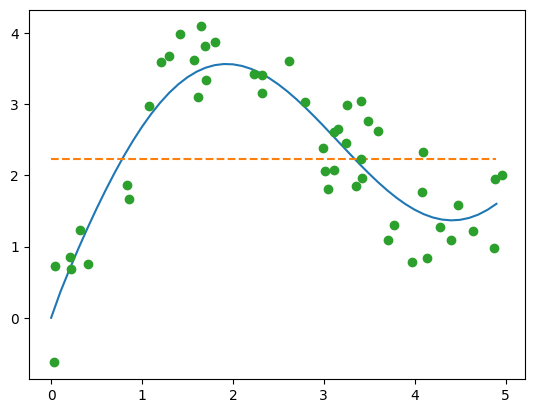

In [56]:
import torch
import matplotlib.pyplot as plt
n_train=50
x_train,_ = torch.sort(torch.rand(n_train)*5)

def f(x):
    return 2*torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0,0.5, (n_train,))


x_test = torch.arange(0,5,0.1)
y_truth = f(x_test)

n_test = len(x_test)
n_test

y_hat = y_train.mean().repeat(n_test)

plt.plot(x_test, y_truth)
plt.plot(x_test, y_hat,'--')
plt.plot(x_train, y_train, 'o')

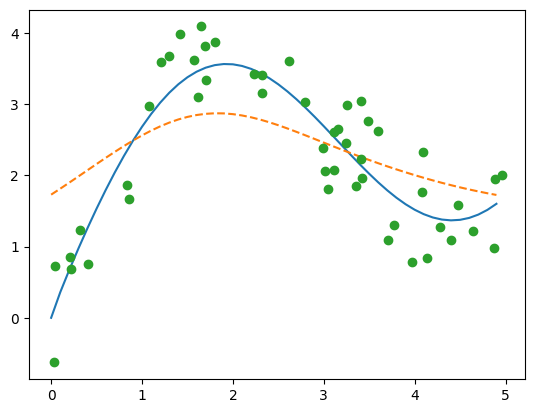

In [62]:
x_repeat = x_test.repeat_interleave(n_train).reshape(-1,n_train)

attention_weights = torch.softmax(-(x_repeat - x_train)**2/2, dim=1)

y_hat = torch.matmul(attention_weights,y_train)

plt.plot(x_test, y_truth)
plt.plot(x_test, y_hat,'--')
plt.plot(x_train, y_train, 'o')



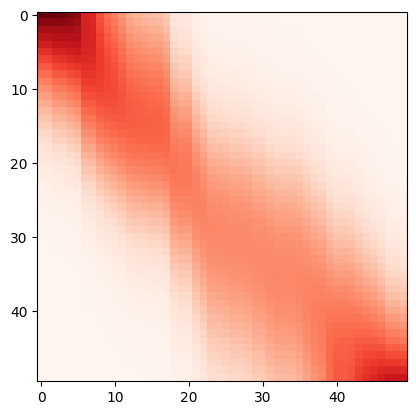

In [63]:
plt.imshow(attention_weights, cmap="Reds")


In [65]:
class NWKernelRegression(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.w = torch.nn.Parameter(torch.rand((1,), requires_grad=True))
    
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1])
        self.attention_weights = torch.softmax(-((queries-keys)*self.w)**2/2,dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [105]:
x_tile = x_train.repeat((n_train,1))
y_tile = y_train.repeat((n_train,1))
keys = x_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
values = y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

net = NWKernelRegression()
loss = torch.nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=0.1)

for epoch in range(10):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')

epoch 1, loss 61.274887
epoch 2, loss 49.326031
epoch 3, loss 13.414075
epoch 4, loss 13.406539
epoch 5, loss 13.399082
epoch 6, loss 13.391721
epoch 7, loss 13.384446
epoch 8, loss 13.377278
epoch 9, loss 13.370212
epoch 10, loss 13.363253


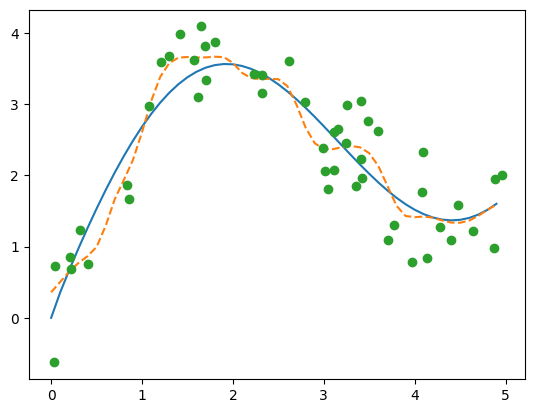

In [106]:

keys = x_train.repeat((n_train,1))
values = y_train.repeat((n_train,1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()

plt.plot(x_test, y_truth)
plt.plot(x_test, y_hat,'--')
plt.plot(x_train, y_train, 'o')



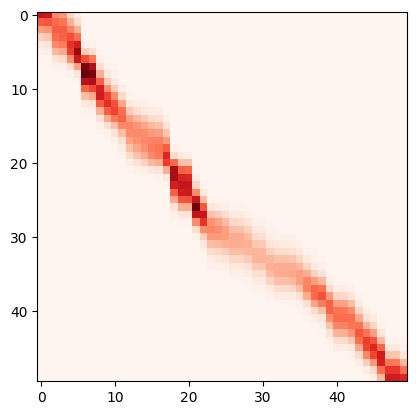

In [107]:
net.attention_weights.shape
plt.imshow(net.attention_weights.detach(), cmap="Reds")